# A simple example on doing Membership Inference Attacks with TensorFlow Privacy

This code is tested to work with:
- Python 3.7
- TensorFlow 2.7
- TensorFlow Privacy 0.7.3



In [31]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# tensorflow imports
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
# install the most recent verson of tensorflow-privacy
!pip install -U git+https://github.com/tensorflow/privacy


  Cloning https://github.com/tensorflow/privacy to /tmp/pip-req-build-afaxjf_8
  Running command git clone -q https://github.com/tensorflow/privacy /tmp/pip-req-build-afaxjf_8


In [37]:
# tensorflow-privacy 
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

## Some helper methods

In [7]:
def load_cifar10():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing CIFAR10 dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.cifar10.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # cifar10 labels come one-hot encoded, there
  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()

  return train_data, train_labels, test_data, test_labels
 
def make_simple_model():
  """ Define a Keras model without much of regularization
  Such a model is prone to overfitting"""
  shape = (32, 32, 3)
  i = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(i)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  # if we don't specify an activation for the last layer, we can have the logits
  x = Dense(10)(x)
  model = Model(i, x)
  return model

In [8]:
train_data, train_labels, test_data, test_labels = load_cifar10()

170508288/170498071 [==============================] - 2s 0us/step


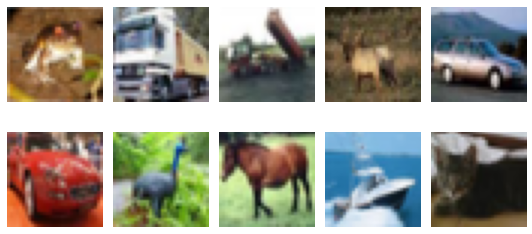

In [9]:
# show some train data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(train_data[i])

plt.tight_layout()
plt.show()

In [10]:
# make the neural network model with the function specified above.
# one model is supposed to train for 10, one for 50 epochs
model = make_simple_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [11]:
# specify parameters
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Model Training
Train the model for 30 epochs. 

The idea is that we can use the TensorFlow Privacy Library on the trained models in order to quantify the membership inference risk respectively. 


In [12]:
# train the model
history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=128, 
                       epochs=30)

Epoch 1/30
391/391 [==============================] - 14s 13ms/step - loss: 1.6588 - accuracy: 0.3896 - val_loss: 1.4134 - val_accuracy: 0.4852
Epoch 2/30
391/391 [==============================] - 5s 12ms/step - loss: 1.3149 - accuracy: 0.5270 - val_loss: 1.2858 - val_accuracy: 0.5464
Epoch 3/30
391/391 [==============================] - 5s 12ms/step - loss: 1.1779 - accuracy: 0.5825 - val_loss: 1.1221 - val_accuracy: 0.6070
Epoch 4/30
391/391 [==============================] - 5s 12ms/step - loss: 1.0721 - accuracy: 0.6202 - val_loss: 1.0901 - val_accuracy: 0.6144
Epoch 5/30
391/391 [==============================] - 5s 13ms/step - loss: 0.9879 - accuracy: 0.6532 - val_loss: 1.0055 - val_accuracy: 0.6517
Epoch 6/30
391/391 [==============================] - 5s 12ms/step - loss: 0.9291 - accuracy: 0.6736 - val_loss: 0.9920 - val_accuracy: 0.6530
Epoch 7/30
391/391 [==============================] - 4s 11ms/step - loss: 0.8697 - accuracy: 0.6956 - val_loss: 0.9960 - val_accuracy: 0.648

(0.0, 1.0)

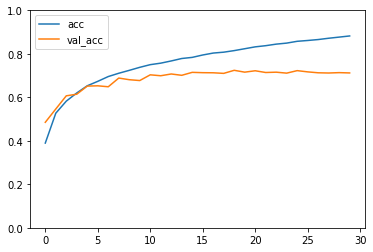

In [13]:
# plot accuracy for the first model
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

### Attack on the model

In [26]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = model.predict(train_data)
print('Predict on test...')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = tf.nn.softmax(logits_train, axis=-1)
prob_test = tf.nn.softmax(logits_test)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...


In [33]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

In [34]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [35]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

In [38]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [39]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 2878 training and 2878 test examples) achieved an AUC of 0.71 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 2878 training and 2878 test examples) achieved an advantage of 0.35 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an AUC of 0.61
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an advantage of 0.18

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.60
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.18

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.60
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an advantage of 

Figure(432x288)


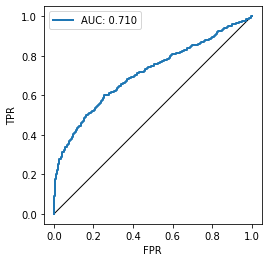

In [41]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))